# Measuring bias in recommender systems

This is an introduction to fairness in recommender systems. A recommender system aims to recommend the best item according to the user preference. In this tutorial, we will focus on the task of correctly predicting users' music preference.

A recommender system can be biased in multiple ways. For example, we may be concerned that the artists in our database will not get equal representation (item fairness). Alternative, our main concern may be that different groups of users (e.g. male/female users) will get different music recommendations (user fairness). In the following, we will show how to explore the data for fairness, and measure these various types of fairness using the holisticai library.

## Importing the data

We will start by importing the example dataset, which we host on our library. The [datatset](https://www.kaggle.com/datasets/ravichaubey1506/lastfm) contains a set of artists that were downloaded by users. It includes personal information about the user, specifically sex and country of origin. A user can download more than one artist. We will use the column "score", which contains only 1s for counting the interactions.

In [1]:
import numpy as np
import pandas as pd
import sys
sys.path.append('../')
from holisticai.datasets import load_last_fm

bunch = load_last_fm()
lastfm = bunch['frame']
lastfm

user                   artist sex  country
0           1.0    red hot chili peppers   f  Germany
1           1.0  the black dahlia murder   f  Germany
2           1.0                goldfrapp   f  Germany
3           1.0         dropkick murphys   f  Germany
4           1.0                 le tigre   f  Germany
...         ...                      ...  ..      ...
289950  19718.0                bob dylan   f   Canada
289951  19718.0                   pixies   f   Canada
289952  19718.0                the clash   f   Canada
289953  19718.0     a tribe called quest   f   Canada
289954  19718.0                radiohead   f   Canada

[289955 rows x 4 columns]

We now need to change the dataframe to an interaction matrix, where every row is a user and every column is an artist. We can use the formatting function provided in the library, the output dataframe can be used as an input to the bias metric functions for recommenders.

In [2]:
# import formatters
from holisticai.utils import recommender_formatter

# Each interaction results in a non-nan entry in the dataframe.
df_pivot, p_attr = recommender_formatter(lastfm, users_col='user', groups_col='sex', items_col='artist', scores_col='score')

## Plotting and Data Exploration

We will now move to data exploration, using some of the functions for plotting available in our library.

In [3]:
# import plotters
from holisticai.bias.plots import group_pie_plot
from holisticai.bias.plots import long_tail_plot
from holisticai.bias.plots import exposure_diff_plot
from holisticai.bias.plots import exposure_ratio_plot

In [4]:
print ('Number of Unique Users : ' + str(df_pivot.shape[0]))
print ('Number of Unique Artists : ' + str(df_pivot.shape[1]))

Number of Unique Users : 15000
Number of Unique Artists : 1004


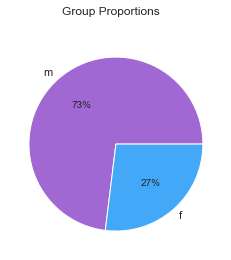

In [5]:
# male vs female representation in data
group_pie_plot(lastfm['sex'])

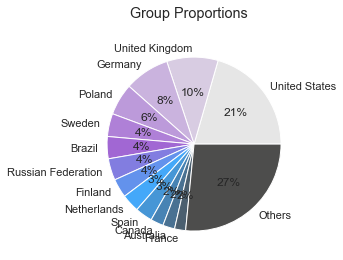

In [6]:
# country representation in data
group_pie_plot(lastfm['country'])

After an initial exploration of the users demographic, we can explore fairness-related plots. The `long_tail_plot` shows the descendent frequency of the items. In this example, the artists' popularity seems falls [exponentially](https://en.wikipedia.org/wiki/Zipf%27s_law) at a pretty fast rate. This can indicate an issue in terms of items fairness (i.e. if we want all artists to be recommended equally).

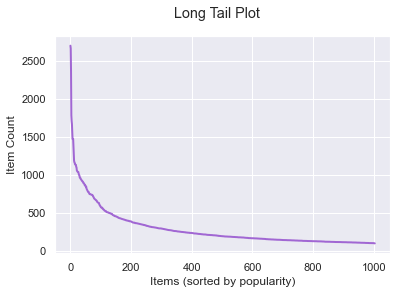

In [7]:
# the long tail plot shows the distribution of item counts
long_tail_plot(df_pivot.to_numpy())

If we are interested in users' fairness instead, we may want to compare how often the same artists are presented to different groups of users. Here, we will focus on the comparison between male and female users. Specifically, we calculate the proportion of male users (out of all male users) who have downloaded each artist. We then compare this value to the corresponding proportion of female users.

The holisticai function `exposure_diff_plot` displays the difference in exposure for each item, while `exposure_ratio_plot` measures the ratio in exposure.

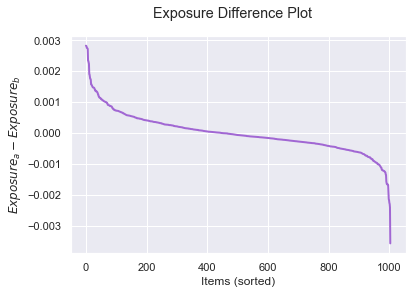

In [8]:
# sorted exposure differences
group_a = p_attr=='f'
group_b = p_attr=='m'
exposure_diff_plot(group_a, group_b, df_pivot.to_numpy())

The differences in exposures seem to be overall quite small. However, since the number of items is quite large, the exposures are small to start with. In these cases, the exposure ratio may be a more informative choice.

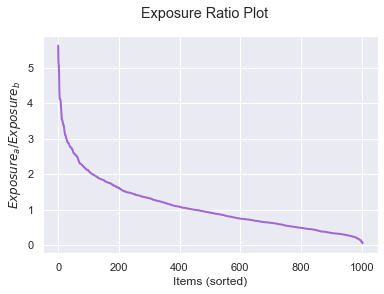

In [9]:
# sorted exposure ratios
exposure_ratio_plot(group_a, group_b, df_pivot.to_numpy())

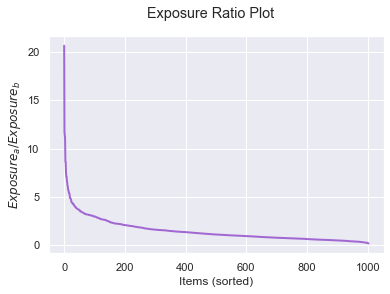

In [10]:
exposure_ratio_plot(group_b, group_a, df_pivot.to_numpy())

The above plots show that there are artists that are more than 5 times more popular amongst the female subgroup than male, and artists that are more than 20 times more popular amongst male rather than female users.

## Evaluate Fairness of Model

We will now show how we can calculate various metrics of fairness for recommender systems. In this example, we will cover both metrics for item fairness and for user fairness (equality of outcome).

### Item Fairness

In [11]:
mat = df_pivot.to_numpy()
group_a = p_attr=='f'
group_b = p_attr=='m'

In [12]:
from holisticai.bias.metrics import aggregate_diversity
aggregate_diversity(mat)

1.0

The above metric shows all artists are shown to at least one user. This makes sense as the dataset is created from the interaction of users with particular artists.

In [13]:
from holisticai.bias.metrics import gini_index
gini_index(mat)

0.4014296448409511

The Gini Index is often used in the context of recommender systems as a measure of how unequal the distribution of exposure is over artists. A value of 0 would indicate perfect fairness, a flat distribution. A value of 1 would be maximally unequal. In this case the GINI Index is 0.4, indicating a considerable amount of difference in exposures overall between different artists. Ultimately this is created by the 'will of the people' so cannot be considered an ethical issue, but is worth noticing.

In [14]:
from holisticai.bias.metrics import recommender_bias_metrics
recommender_bias_metrics(mat_pred=mat, metric_type='item_based')

Value Reference
Metric                                                 
Aggregate Diversity                  1.000000         1
GINI index                           0.401430         0
Exposure Distribution Entropy        6.614933         -
Average Recommendation Popularity  522.811846         -

Above we have batch plotted all item_based metrics for recommender bias task. For instance observe the Average Recommendation Popularity is 522, meaning that on average a user will interact with an artist that has 522 total interactions.

## User fairness - Equality of Outcome

In [15]:
from holisticai.bias.metrics import exposure_l1
exposure_l1(group_a, group_b, mat)

0.22982410678782372

Above we compute the total variation distance between the exposure distribution of males and females. The minimum value for this metric is 0 indicating the two subgroups are exposed to the artists in exactly the same way, the maximum value is 1 indicating a maximal separation in exposures between the two groups. In this case the value of 0.22 shows there is a difference between the taste of males and females in music, but not a drastic one.

In [16]:
from holisticai.bias.metrics import recommender_bias_metrics
recommender_bias_metrics(group_a, group_b, mat, metric_type='equal_outcome')

Value  Reference
Metric                                       
Mean Absolute Deviation   0.000008          0
Exposure Total Variation  0.229824          0
Exposure KL Divergence    0.168021          0

Above we show the batch computation for equality of outcome metrics in a recommender systems setting.